# Flow Matching

Written by [Junkun Yuan](https://junkunyuan.github.io/) (yuanjk0921@outlook.com).

See paper reading list and notes [here](https://junkunyuan.github.io/paper_reading_list/paper_reading_list.html).

Last updated on Aug 23, 2025; &nbsp; First committed on Aug 23, 2025.

**References**

- [**Flow Matching for Generative Modeling** *(ICLR 2023)*](https://arxiv.org/pdf/2210.02747)
- [**Flow Matching Guide and Code** *(arXiv 2024)*](https://arxiv.org/pdf/2412.06264)

**Contents**
- Simple Introduction to Flow Matching
- PyTorch Implementations

## Simple Introduction to Flow Matching

<b>Flow</b> is a deterministic, time-continuous bijective transformation of the d-dimensional Euclidean space $\mathbb{R}^d$.

**Flow Matching (FM)** builds a flow that transforms a sample $X_0\sim p$ drawn from a source distribution $p$ into a target sample $X_1\coloneqq \psi_1(X_0)$ such that $X_1\sim q$ has a desired distribution $q$.

**Processes to achieve FM:** (1) Design a time-continuous probability path interpolating between $p \coloneqq p_0$ and $q \coloneqq p_1$. (2) During training, regress the velocity field $u_t$ known to generate $p_t$. (3) During inference, draw a novel target sample $X_1\sim q$ and integrate the estimated velocity field $u_t^{\theta}(X_t)$ from $t=0$ to $t=1$, where $X_0\sim p$ is a novel source sample.

Given a conditional optimal-transport (or called linear path):

$$X_t=tX_1+(1-t)X_0\sim p_t.$$

Then, the simplest implementation of Flow Matching is

$$L_(\theta)=\mathbb{E}_{t,X_0,X_1}\lVert u_t^\theta(X_t) - (X_1 - X_0)\rVert^2, \text{where } t\sim U[0,1], X_0 \sim \mathcal{N}(0,I), X_1\sim q.$$

## PyTorch Implementations

In [1]:
## --------------------------------------------------------------------------------
## Training configurations
## --------------------------------------------------------------------------------
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # image size for training and inference
    train_batch_size = 128  # batch-size for training 
    eval_batch_size = 16  # batch-size for inference
    num_epochs = 200  # training epochs
    learning_rate = 1e-4  # learning rate 
    lr_warmup_steps = 100  # warmup steps
    show_image_epochs = 50  # epochs to inference and show
    seed = 0  # random seed

config = TrainingConfig()

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
Using the latest cached version of the dataset since huggan/smithsonian_butterflies_subset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/huggan___smithsonian_butterflies_subset/default/0.0.0/3cdedf844922ab40393d46d4c7f81c596e1c6d45 (last modified on Sat Aug  9 17:23:33 2025).


=> Training samples: 1000, training batch-size: 128, 8 iters per epoch, 1600 iters in total


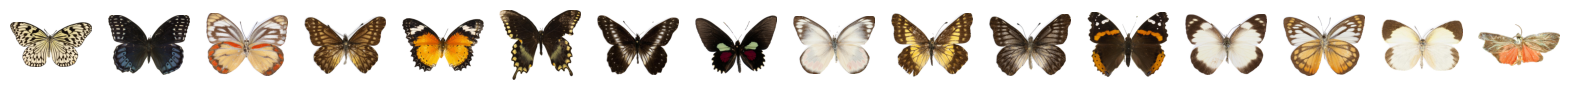

In [2]:
## --------------------------------------------------------------------------------
## Prepare dataset and data loader
## --------------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

## Load dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

## Visualize dataset
fig, axs = plt.subplots(1, 16, figsize=(20, 4))
for i, image in enumerate(dataset[0:160:10]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Create preprocessing pipeline
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
dataset.set_transform(transform)

## Build data loader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=8, pin_memory=True)

all_steps = config.num_epochs * len(train_dataloader) 
print(f"=> Training samples: {len(dataset)}, training batch-size: {train_dataloader.batch_size}, {len(train_dataloader)} iters per epoch, {all_steps} iters in total")

In [3]:
## --------------------------------------------------------------------------------
## Build a diffusion model
## --------------------------------------------------------------------------------
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # input sample size
    in_channels=3,  # input channels
    out_channels=3,  # output channels
    layers_per_block=2,  # how many ResNet layers per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [4]:
## --------------------------------------------------------------------------------
## Prepare optimizer and learning rate scheduler
## --------------------------------------------------------------------------------
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [5]:
import numpy as np
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler

class MyFlowMatchEulerDiscreteScheduler:
    """
    Simple implementation of the Flow Matching scheduler.
    Borrowed from FlowMatchEulerDiscreteScheduler of diffusers.
    """
    def __init__(self, num_train_timesteps=1000, shift=1.):
        timesteps = np.linspace(1, num_train_timesteps, num_train_timesteps, dtype=np.float32)[::-1].copy()
        timesteps = torch.from_numpy(timesteps).to(dtype=torch.float32)
        sigmas = timesteps / num_train_timesteps
        sigmas = shift * sigmas / (1 + (shift - 1) * sigmas)
        self.timesteps = sigmas * num_train_timesteps
        # self.sigmas = sigmas.to("cpu")
        self.sigmas = sigmas
        self.sigma_min = self.sigmas[-1].item()
        self.sigma_max = self.sigmas[0].item()
        self.num_train_timesteps = num_train_timesteps
        self.shift = shift

    def scale_noise(self, sample, timestep, noise):
        ## Align device and dtype
        sigmas = self.sigmas.to(device=sample.device, dtype=sample.dtype)
        schedule_timesteps = self.timesteps.to(sample.device)
        timestep = timestep.to(sample.device)

        ## Map from indices to sigmas
        step_indices = [(schedule_timesteps == t).nonzero()[0].item() for t in timestep]
        sigma = sigmas[step_indices].flatten()
        while len(sigma.shape) < len(sample.shape):
            sigma = sigma.unsqueeze(-1)

        return sigma * noise + (1.0 - sigma) * sample
        
    def set_timesteps(self, num_inference_steps):
        ## Split timesteps
        timesteps = np.linspace(
            self.sigma_max * self.num_train_timesteps,
            self.sigma_min * self.num_train_timesteps,
            num_inference_steps
        )
        
        ## Shift sigma
        sigmas = timesteps / self.num_train_timesteps
        sigmas = self.shift * sigmas / (1 + (self.shift - 1) * sigmas)
        sigmas = torch.from_numpy(sigmas).to(dtype=torch.float32, device=device)
        
        timesteps = sigmas * self.num_train_timesteps
        sigmas = torch.cat([sigmas, torch.zeros(1, device=sigmas.device)])
        self.timesteps = timesteps
        self.sigmas = sigmas
        
    def step(self, model_output, timestep, sample):
        sigma_idx = (schedule_timesteps == t).nonzero()[0].item()
        sigma = self.sigmas[sigma_idx]
        sigma_next = self.sigmas[sigma_idx + 1]
        dt = sigma_next - sigma
        prev_sample = sample + dt * model_output
        return prev_sample,

noise_scheduler = MyFlowMatchEulerDiscreteScheduler()

Timesteps to add noise: [1000.0, 950.0, 900.0, 850.0, 800.0, 750.0, 700.0, 650.0, 600.0, 550.0, 500.0, 450.0, 400.0, 350.0, 300.0, 250.0, 200.0, 150.0, 100.0, 50.0]


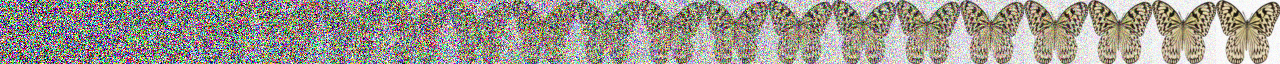

In [6]:
## --------------------------------------------------------------------------------
## Visualize the process of adding noise to clean data
## --------------------------------------------------------------------------------
from PIL import Image
from diffusers.utils import make_image_grid

def make_image_grid(images, rows, cols, resize=None):
    """Display PIL Images."""
    """Borrowed from diffusers: https://github.com/huggingface/diffusers/blob/main/src/diffusers/utils/pil_utils.py"""
    assert len(images) == rows * cols
    if resize is not None:
        images = [img.resize((resize, resize)) for img in images]
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid
    
def tensor2pil(tensor):
    """Transform PyTorch Tensor to list of PIL Image."""
    tensor = tensor.detach().to("cpu")
    tensor = tensor.permute(0, 2, 3, 1)
    tensor = torch.clamp((tensor + 1) / 2 * 255, min=0, max=255)
    tensor = tensor.numpy().astype(np.uint8)
    tensor = [Image.fromarray(t) for _, t in enumerate(tensor)]
    return tensor

## Get a clean data and repeat it 20 times
clean_images = dataset[0:1]["images"][0].unsqueeze(0).repeat(20, 1, 1, 1)
noise = torch.randn(clean_images.shape, device=clean_images.device)

## Build timesteps from 0 to 999 with interval of 50
timesteps = noise_scheduler.timesteps[::50]
print("Timesteps to add noise:", timesteps.tolist())

## Add noise to clean data
noisy_images = noise_scheduler.scale_noise(sample=clean_images, noise=noise, timestep=timesteps)

## Visualize noisy data
noisy_images_pil = tensor2pil(noisy_images)
samples_pil = make_image_grid(noisy_images_pil, rows=1, cols=20)
display(samples_pil)

Detected kernel version 5.4.241, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


=> Global_step: 0001/1600, loss: 1.7336, lr: 0.000001
inference steps: [2, 4, 999], time cost (s): [0.1, 0.1, 21.3]


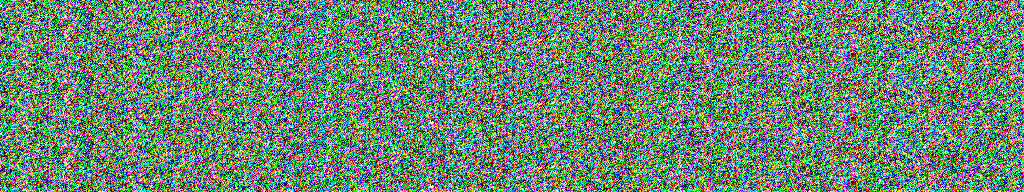

=> Global_step: 0050/1600, loss: 0.2980, lr: 0.000050
=> Global_step: 0100/1600, loss: 0.2026, lr: 0.000100
=> Global_step: 0150/1600, loss: 0.1531, lr: 0.000100
=> Global_step: 0200/1600, loss: 0.1240, lr: 0.000099
=> Global_step: 0250/1600, loss: 0.1201, lr: 0.000098
=> Global_step: 0300/1600, loss: 0.1188, lr: 0.000096
=> Global_step: 0350/1600, loss: 0.1052, lr: 0.000093
=> Global_step: 0400/1600, loss: 0.1095, lr: 0.000090
inference steps: [2, 4, 999], time cost (s): [0.1, 0.1, 21.3]


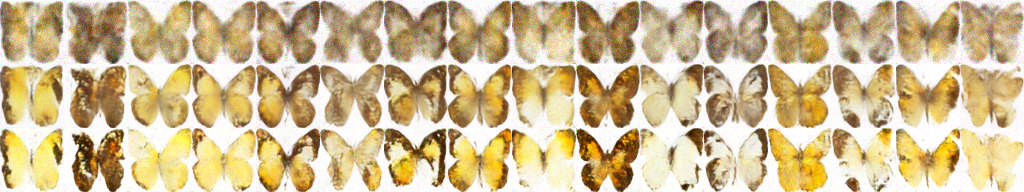

=> Global_step: 0450/1600, loss: 0.1023, lr: 0.000087
=> Global_step: 0500/1600, loss: 0.0961, lr: 0.000083
=> Global_step: 0550/1600, loss: 0.0921, lr: 0.000079
=> Global_step: 0600/1600, loss: 0.0908, lr: 0.000075
=> Global_step: 0650/1600, loss: 0.0945, lr: 0.000070
=> Global_step: 0700/1600, loss: 0.0921, lr: 0.000065
=> Global_step: 0750/1600, loss: 0.0912, lr: 0.000060
=> Global_step: 0800/1600, loss: 0.0913, lr: 0.000055
inference steps: [2, 4, 999], time cost (s): [0.0, 0.1, 21.3]


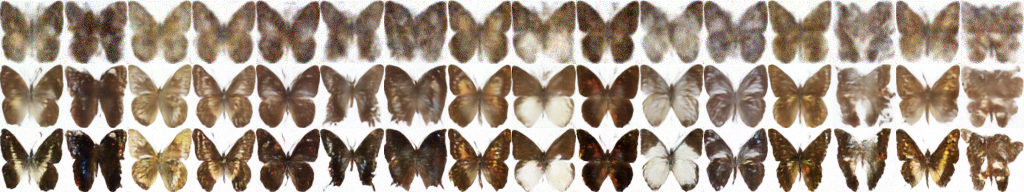

=> Global_step: 0850/1600, loss: 0.0853, lr: 0.000050
=> Global_step: 0900/1600, loss: 0.0804, lr: 0.000045
=> Global_step: 0950/1600, loss: 0.0802, lr: 0.000040
=> Global_step: 1000/1600, loss: 0.0849, lr: 0.000035
=> Global_step: 1050/1600, loss: 0.0790, lr: 0.000030
=> Global_step: 1100/1600, loss: 0.0828, lr: 0.000025
=> Global_step: 1150/1600, loss: 0.0860, lr: 0.000021
=> Global_step: 1200/1600, loss: 0.0769, lr: 0.000017
inference steps: [2, 4, 999], time cost (s): [0.0, 0.1, 21.5]


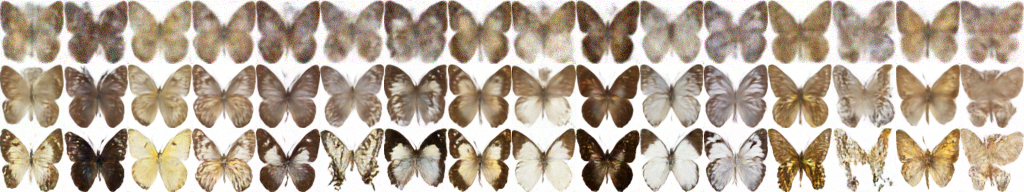

=> Global_step: 1250/1600, loss: 0.0773, lr: 0.000013
=> Global_step: 1300/1600, loss: 0.0739, lr: 0.000010
=> Global_step: 1350/1600, loss: 0.0801, lr: 0.000007
=> Global_step: 1400/1600, loss: 0.0854, lr: 0.000004
=> Global_step: 1450/1600, loss: 0.0751, lr: 0.000002
=> Global_step: 1500/1600, loss: 0.0795, lr: 0.000001
=> Global_step: 1550/1600, loss: 0.0757, lr: 0.000000
=> Global_step: 1600/1600, loss: 0.0713, lr: 0.000000
inference steps: [2, 4, 999], time cost (s): [0.1, 0.1, 21.4]


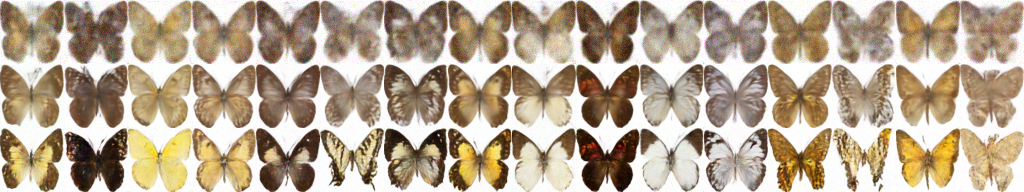

=> Finish training!


In [11]:
## --------------------------------------------------------------------------------
## Start training
## --------------------------------------------------------------------------------
import time
import random
import torch.nn.functional as F
from accelerate import Accelerator

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    ## Initialize Accelerator
    accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)

    ## Training loop
    global_step = 0
    for epoch in range(config.num_epochs):
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            
            ## Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            ## Construct noisy data
            u = torch.normal(mean=0., std=1., size=(bs,))
            w = 1 / (1 + torch.exp(-u))
            sigma = (noise_scheduler.shift * w) / (1 + (noise_scheduler.shift - 1) * w)
            sigma = sigma.to(device=clean_images.device)
            timesteps = sigma * noise_scheduler.num_train_timesteps
            sigma = sigma.view(-1, 1, 1, 1)
            noisy_images = (1 - sigma) * clean_images + sigma * noise

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps).sample
                loss = F.mse_loss(noise_pred, noise - clean_images)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            loss_item = loss.detach().item()
            lr = lr_scheduler.get_last_lr()[0]
            global_step += 1

            if global_step == 1 or global_step % 50 == 0:
                print(f"=> Global_step: {global_step:04d}/{all_steps:04d}, loss: {loss_item:.4f}, lr: {lr:.6f}")

        ## Sample images and save the model
        if accelerator.is_main_process:
            if (epoch + 1) == 1 or (epoch + 1) % config.show_image_epochs == 0 or epoch == config.num_epochs - 1:
                infer_steps_list = [infer_steps for infer_steps in [2, 4, 999]]

                ## Infer
                search = len(infer_steps_list)
                scheduler = FlowMatchEulerDiscreteScheduler()
                model_ = accelerator.unwrap_model(model)
                device, dtype = model_.device, model_.dtype
                                    
                images_result, time_cost = list(), list()
                for infer_steps in infer_steps_list:
                    start_time = time.time()
                    gen = torch.Generator(device='cuda').manual_seed(config.seed)

                    ## Denoising loop
                    image_shape = (config.eval_batch_size, model_.config.in_channels, model_.config.sample_size, model_.config.sample_size)
                    image = torch.randn(image_shape, generator=gen, device=device, dtype=dtype)
                    scheduler.set_timesteps(infer_steps)
                    with torch.no_grad():
                        for t in scheduler.timesteps:
                            v = model_(image, t).sample
                            image = scheduler.step(model_output=v, timestep=t, sample=image, generator=gen)[0]
                    
                    images = tensor2pil(image)
                    images_result = images_result + images
                    end_time = time.time()
                    time_cost.append(round(end_time - start_time, 1))
                print(f"inference steps: {infer_steps_list}, time cost (s): {time_cost}")

                ## Display results
                image_grid = make_image_grid(images_result, rows=search, cols=len(images_result)//search)
                display(image_grid)
    print("=> Finish training!")

train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)